## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [1]:
from datetime import datetime, timedelta
import os
from zipfile import ZipFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import plotly.graph_objects as go
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

%matplotlib inline

In [2]:
url ='south_korea_covid19.zip'
with ZipFile(url, 'r') as zf:
    with zf.open(zf.namelist()[0], 'r') as f:
        df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [3]:
df.shape

(2218, 18)

In [4]:
#Counts of null values 
na_df = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [5]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [6]:
df['n_age'] = 2020 - df.birth_year

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [8]:
df.disease.fillna(0, inplace=True)
df.disease.replace('True', 1, inplace=True)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [9]:
cols = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']

for col in cols:
    df[col].fillna(df[col].mean(), inplace=True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [10]:
updated = df.isnull().sum().sort_values(ascending=False).reset_index()
updated.columns = ['vars', 'null_counts']
remaining_cols = updated[updated.null_counts > 0].vars.to_list()

for col in remaining_cols:
    val = df[col].mode()[0] if df[col].dtype == 'object' else float(df[col].mode())
    df[col].fillna(val, inplace=True)

 **<font color='teal'> Check for any remaining null values.</font>**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          2218 non-null   float64
 2   sex                 2218 non-null   object 
 3   birth_year          2218 non-null   float64
 4   age                 2218 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2218 non-null   object 
 8   disease             2218 non-null   object 
 9   infection_case      2218 non-null   object 
 10  infection_order     2218 non-null   float64
 11  infected_by         2218 non-null   float64
 12  contact_number      2218 non-null   float64
 13  symptom_onset_date  2218 non-null   object 
 14  confirmed_date      2218 non-null   object 
 15  released_date       2218 non-null   object 
 16  deceas

In [12]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,2020-02-23,released,56.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,2020-02-27,2020-01-30,2020-03-02,2020-02-23,released,33.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,2020-02-27,2020-01-30,2020-02-19,2020-02-23,released,56.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,2020-02-23,released,29.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,2020-02-27,2020-01-31,2020-02-24,2020-02-23,released,28.0


Remove date columns from the data.


In [13]:
to_drop = [
    'symptom_onset_date', 
    'confirmed_date',
    'released_date',
    'deceased_date',
    'global_num'
]

df = df.drop(to_drop, axis =1)

Review the count of unique values by column.

In [14]:
print(df.nunique())

df.disease.value_counts()

patient_id         2218
sex                   2
birth_year           97
age                  11
country               4
province             17
city                134
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                96
dtype: int64


0       2199
True      19
Name: disease, dtype: int64

Review the percent of unique values by column.

In [15]:
print(df.nunique() / df.shape[0] * 100)

patient_id         100.000000
sex                  0.090171
birth_year           4.373309
age                  0.495942
country              0.180343
province             0.766456
city                 6.041479
disease              0.090171
infection_case       0.721371
infection_order      0.315600
infected_by          9.332732
contact_number       3.291253
state                0.135257
n_age                4.328224
dtype: float64


Review the range of values per column.

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2218.0,4.014678e+09,2.192419e+09,1.000000e+09,1.700000e+09,6.001000e+09,6.004000e+09,7.000000e+09
birth_year,2218.0,1.974989e+03,1.731123e+01,1.916000e+03,1.965000e+03,1.974989e+03,1.988000e+03,2.020000e+03
infection_order,2218.0,2.285714e+00,1.706622e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2218.0,2.600789e+09,7.216328e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2218.0,2.412895e+01,3.917141e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2218.0,4.623715e+01,1.747912e+01,0.000000e+00,3.200000e+01,5.100000e+01,5.500000e+01,1.040000e+02


### Check for duplicated rows

In [17]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [18]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(dfo.shape)

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values('LevelsCount', ascending =False, inplace=True)
vn

(2218, 8)


,VarName,LevelsCount
4,city,134
3,province,17
6,infection_case,16
1,age,11
2,country,4
7,state,3
0,sex,2
5,disease,2


**<font color='teal'> Plot the correlation heat map for the features.</font>**

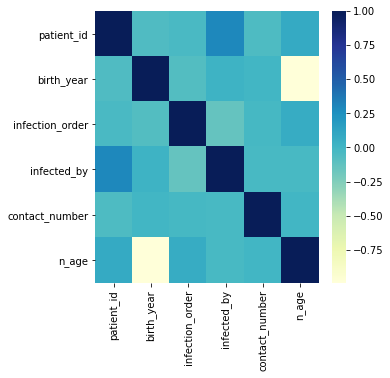

In [19]:
plt.figure(figsize=(5, 5))
_ = sns.heatmap(df.corr(), cmap='YlGnBu')

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

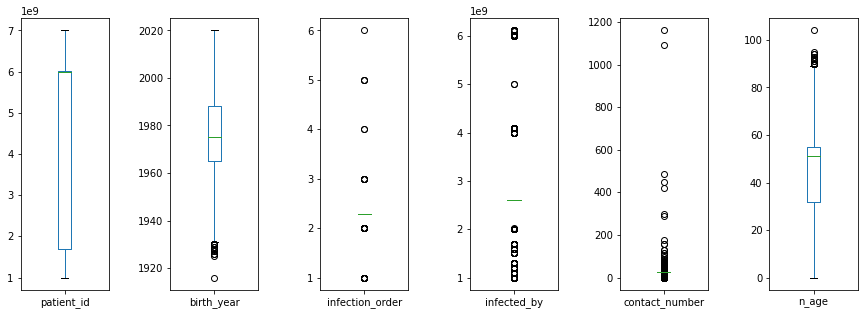

In [20]:
_ = df.plot(kind='box', subplots=True, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)

**<font color='teal'> Create dummy features for object type features. </font>**

In [21]:
# Separate predictors and responses
X = df.drop('state', axis=1)
y = df.state

# Create dummy variables for predictors
X = pd.get_dummies(X)

### Split the data into test and train subsamples

In [22]:
# Though the original instructions say we should standardize the sample first 
# then devide into test/training data, this causes data leakage (especially
# because we have no idea on the underlaying distribution). So, we should 
# devide the data and then standardize if ever need.
# Random forest or any decision tree doesn't require scaling. So I'm not going
# to perform any.

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8, random_state=1)

### Scale data to prep for model creation

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier

In [24]:
import time
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:, 1]

#lr_auc = roc_auc_score(y_test, lr_probs)
ac = accuracy_score(y_test, y_pred)
#lo = log_loss(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

#print('Training Data Set 1 RandomForest: ROC AUC=%.3f' % (lr_auc))
print('Training Data Set 1 Random Forest: Accuracy=%.3f' % (ac))
#print('Training Data Set 1 Random Forest: Log loss=%.3f' % (lo))
print('Training Data Set 1 Random Forest: f1-score=%.3f' % (f1))

Training Data Set 1 Random Forest: Accuracy=0.843
Training Data Set 1 Random Forest: f1-score=0.808


### Create Confusion Matrix Plots

In [25]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  13   10    0]
 [   0 1454   49]
 [   0  219   30]]
Normalized confusion matrix
[[0.57 0.43 0.  ]
 [0.   0.97 0.03]
 [0.   0.88 0.12]]


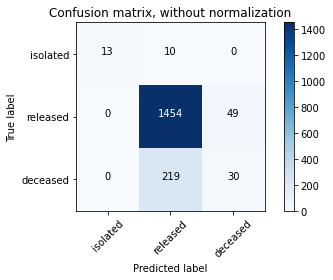

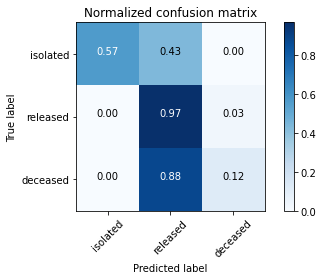

In [26]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from typing import List, NoReturn

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm: np.ndarray, 
                          classes: List[str],
                          normalize: bool = False,
                          title: str = 'Confusion matrix',
                          cmap: LinearSegmentedColormap = plt.cm.Blues) -> NoReturn:
    """
    Prints and plots the confusion matrix.
    
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances

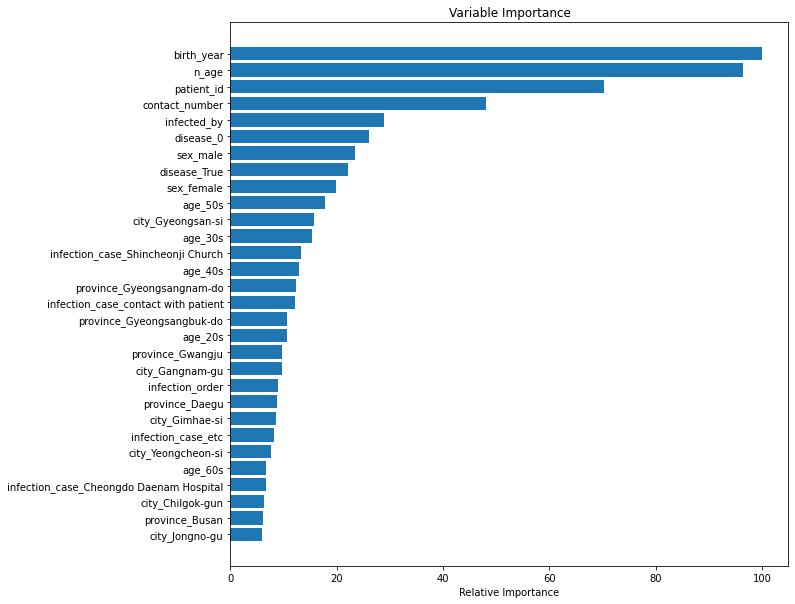

In [27]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort((-feature_importance))[:30][::-1]

pos = np.arange(sorted_idx.shape[0]) + .5
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model does not. In this case study, you saw the performance ability even with only a few features and almost all of them were highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features within a large dataset. Random forest should be your first choice you turn to when building a decision tree, especially when working with multiclass classifications.